In [1]:
import KID_model_functions as kids
import fitting_KID_model_functions as fitkids
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from scipy.optimize import curve_fit
from astropy import units as u, constants as c
from glob import glob

In [2]:
save=False
plotlabel='fitting-masktrans_etaopt_moredata_unbounded_rev'
#trans = 0.03

In [3]:
alpha = 0.73*u.dimensionless_unscaled
f = 331.6*u.MHz
Tstage = 0.215*u.K
Tc = 1.39*u.K
TBB_0 = 6.0*u.K
V = 38*1.5*0.8*np.power(u.micron,3) # volume w/20nm film is 38um3, multiply by 1.5 for ~30nm film, minus 20% for overetching trace width
eta_pb = 0.57
nu_opt = (350*u.micron).to(u.GHz,equivalencies=u.spectral())
N0=1.72e10*np.power(u.micron,-3)*np.power(u.eV,-1)

In [4]:
res = 0

In [5]:
# CD010 and CD013: full optical, no OD mask
cd010file = 'optical_response_evap_devices/CD010_reduced_Res'+str(res)+'.csv'
cd013file = 'optical_response_evap_devices/CD013_reduced_Res'+str(res)+'.csv'
TBBoptdata10,f0optdata10,xoptdata10,sxxoptdata10 = np.loadtxt(cd010file,delimiter=',',unpack=True)
TBBoptdata13,f0optdata13,xoptdata13,sxxoptdata13 = np.loadtxt(cd013file,delimiter=',',unpack=True)
TBBfulloptdata = np.hstack((TBBoptdata10,TBBoptdata13))
f0fulloptdata = np.hstack((f0optdata10,f0optdata13))
xfulloptdata = np.hstack((xoptdata10,xoptdata13))
sxxfulloptdata = np.hstack((sxxoptdata10,sxxoptdata13))

TBBfulloptpts = np.sort(list(set(TBBfulloptdata)))
f0fulloptpts = []
f0fullopterr = []
xfulloptpts = []
xfullopterr = []
sxxfulloptpts = []
sxxfullopterr = []

ix = np.where(kids.TBB_to_Pinc(TBBfulloptpts)<1*u.pW)
for temp in TBBfulloptpts[ix]:
    inds = np.where(TBBfulloptdata == temp)
    
    f0fulloptpts.append(np.average(f0fulloptdata[inds]))
    f0fullopterr.append(np.std(f0fulloptdata[inds])/np.sqrt(len(inds)))
    
    xfulloptpts.append(np.average(xfulloptdata[inds]))
    xfullopterr.append(np.std(xfulloptdata[inds])/np.sqrt(len(inds)))
    
    sxxfulloptpts.append(np.average(sxxfulloptdata[inds]))
    sxxfullopterr.append(np.std(sxxfulloptdata[inds])/np.sqrt(len(inds)))
TBBfulloptpts = TBBfulloptpts[ix]

In [6]:
# CD012: stycast mask in place, nominally 3% transmissivity
TBBoptdata,f0optdata,xoptdata,sxxoptdata = np.loadtxt('optical_response_evap_devices/CD012_reduced_Res0.csv',delimiter=',',unpack=True)

TBBoptpts = np.sort(list(set(TBBoptdata)))

f0optpts = []
f0opterr = []
xoptpts = []
xopterr = []
sxxoptpts = []
sxxopterr = []

for temp in TBBoptpts:
    inds = np.where(TBBoptdata == temp)
    
    f0optpts.append(np.average(f0optdata[inds]))
    f0opterr.append(np.std(f0optdata[inds])/np.sqrt(len(inds)))
    
    xoptpts.append(np.average(xoptdata[inds]))
    xopterr.append(np.std(xoptdata[inds])/np.sqrt(len(inds)))
    
    sxxoptpts.append(np.average(sxxoptdata[inds]))
    sxxopterr.append(np.std(sxxoptdata[inds])/np.sqrt(len(inds)))

In [7]:
# CD011: dark tests
Tstagedarkdata,f0darkdata,xdarkdata,sxxdarkdata = np.loadtxt('optical_response_evap_devices/CD011_reduced_Res0.csv',delimiter=',',unpack=True)

Tstagedarkpts = np.sort(list(set(Tstagedarkdata)))
f0darkpts = []
f0darkerr = []
xdarkpts = []
xdarkerr = []
sxxdarkpts = []
sxxdarkerr = []

for temp in Tstagedarkpts:
    inds = np.where(Tstagedarkdata == temp)
    
    f0darkpts.append(np.average(f0darkdata[inds]))
    f0darkerr.append(np.std(f0darkdata[inds])/np.sqrt(len(inds)))
    
    xdarkpts.append(np.average(xdarkdata[inds]))
    xdarkerr.append(np.std(xdarkdata[inds])/np.sqrt(len(inds)))
    
    sxxdarkpts.append(np.average(sxxdarkdata[inds]))
    sxxdarkerr.append(np.std(sxxdarkdata[inds])/np.sqrt(len(inds)))

In [8]:
# Parameters to hold constant in the fit
alpha = 0.73*u.dimensionless_unscaled
f = 331.6*u.MHz
Tstage = 0.215*u.K
Tc = 1.39*u.K
TBB_0 = 6.0*u.K
V = 38*1.5*0.8*np.power(u.micron,3) # volume w/20nm film is 38um3, multiply by 1.5 for ~30nm film, minus 20% for overetching trace width
eta_pb = 0.57
nu_opt = (350*u.micron).to(u.GHz,equivalencies=u.spectral())
N0=1.72e10*np.power(u.micron,-3)*np.power(u.eV,-1)

# Data to pass into fitter
xdata = np.concatenate((TBBoptpts,TBBfulloptpts,TBBoptpts,Tstagedarkpts))
ydata = np.concatenate((xoptpts,sxxfulloptpts,sxxoptpts,sxxdarkpts))
yerr = np.concatenate((xopterr,sxxfullopterr,sxxopterr,sxxdarkerr))
p0 = [200,50,0.03,.8,1e-8,.5e-17,.5e-17]
bounds = ([10,10,0,0,-1,1e-19,1e-19],[1e5,1e3,.1,1,1,np.min(sxxoptpts),np.min(sxxdarkpts)])

i1 = len(xoptpts)
i2 = i1+len(sxxfulloptpts)
i3 = i2+len(sxxoptpts)

print(len(xdata),len(ydata))

26 26


In [9]:
np.array(sxxfullopterr)/np.array(sxxfulloptpts)

array([0.03378509, 0.03415506, 0.039249  , 0.06352569, 0.03231629,
       0.02809428])

In [10]:
# function to fit x vs TBB
xoptfunc = lambda T_BBi,n_starp,tau_maxp,transp,eta_optp,dfp: kids.xMB(alpha,f,Tstage,Tc,T_BBi,V,n_starp,tau_maxp,eta_pb,eta_optp,transp,N0)+(dfp*f.value)

# function to fit Sxx vs TBB (no mask; T = 1)
sxxfulloptfunc = lambda T_BBi,n_starp,tau_maxp,eta_optp,Sxx0optp: kids.Sxx(alpha,f,Tstage,Tc,T_BBi,V,n_starp,tau_maxp,eta_pb,nu_opt,eta_optp,trans=1,N0=N0).value+Sxx0optp

# function to fit Sxx vs TBB, including mask transparency as free parameter
sxxoptfunc = lambda T_BBi,n_starp,tau_maxp,transp,eta_optp,Sxx0optp: kids.Sxx(alpha,f,Tstage,Tc,T_BBi,V,n_starp,tau_maxp,eta_pb,nu_opt,eta_optp,transp,N0).value+Sxx0optp

# function to fit Sxx vs Tstage
sxxdarkfunc = lambda T_stagei,n_starp,tau_maxp,Sxx0darkp: kids.Sxx(alpha,f,T_stagei,Tc,TBB_0,V,n_starp,tau_maxp,eta_pb,nu_opt,eta_opt=0,trans=0,N0=N0).value+Sxx0darkp

combfunc = lambda datai,n_starp,tau_maxp,transp,eta_optp,dfp,Sxx0optp,Sxx0darkp: np.concatenate((xoptfunc(datai[0:i1],n_starp,tau_maxp,transp,eta_optp,dfp),
                                                                                                 sxxfulloptfunc(datai[i1:i2],n_starp,tau_maxp,eta_optp,Sxx0optp),
                                                                                                 sxxoptfunc(datai[i2:i3],n_starp,tau_maxp,transp,eta_optp,Sxx0optp),
                                                                                                 sxxdarkfunc(datai[i3::],n_starp,tau_maxp,Sxx0darkp)))

In [11]:
#comb_popt,comb_pcov = curve_fit(combfunc,xdata,ydata,p0=p0,sigma=yerr,bounds=bounds,absolute_sigma=True)
comb_popt,comb_pcov = curve_fit(combfunc,xdata,ydata,p0=p0,sigma=yerr,absolute_sigma=True)
print(comb_popt)

comb_perr = np.sqrt(np.diag(comb_pcov))
print(comb_perr)

C:\Users\Alyssa\Anaconda3\lib\site-packages\astropy\units\quantity.py:639: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Alyssa\Anaconda3\lib\site-packages\astropy\units\quantity.py:639: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[2.17437936e+02 4.55224860e+01 1.40478421e-02 3.05413586e-01
 3.57329147e-08 8.16673442e-18 7.51020717e-18]
[2.33224221e+01 5.88252107e+00 3.01595017e-03 8.55857049e-02
 8.59787619e-11 1.75792723e-18 1.05420558e-18]


In [37]:
n_star_fit,tau_max_fit,trans,eta_opt_fit,df_fit,Sxx0opt_fit,Sxx0dark_fit = comb_popt

Tstagefit = np.linspace(Tstagedarkpts.min(),Tstagedarkpts.max(),num=50)
sxxdarkfit = sxxdarkfunc(Tstagefit,n_star_fit,tau_max_fit,Sxx0dark_fit)

# midpoint between full and 3% mask is 0.03 pW; with trans fit this corresponds to 10.6 K
TBBfit = np.linspace(0,10.6,num=50)
xoptfit = xoptfunc(TBBfit,n_star_fit,tau_max_fit,trans,eta_opt_fit,df_fit)
sxxoptfit = sxxoptfunc(TBBfit,n_star_fit,tau_max_fit,trans,eta_opt_fit,Sxx0opt_fit)

SxxGphoton = kids.Sxx_G_photon(alpha,f,Tstage,Tc,TBBfit,V,n_star_fit,tau_max_fit,eta_pb,nu_opt,eta_opt_fit,trans,N0)
SxxRphoton = kids.Sxx_R_photon(alpha,f,Tstage,Tc,TBBfit,V,n_star_fit,tau_max_fit,eta_pb,nu_opt,eta_opt_fit,trans,N0)
SxxGRth = kids.Sxx_GR_th(alpha,f,Tstage,Tc,TBBfit,V,n_star_fit,tau_max_fit,eta_pb,nu_opt,eta_opt_fit,trans,N0)

C:\Users\Alyssa\Anaconda3\lib\site-packages\astropy\units\quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [34]:
# midpoint between full and 3% mask is 0.03 pW; with T=1 this corresponds to 5.01 K
TBBfulloptfit = np.linspace(5.01,2*TBBoptpts.max(),num=50)
#TBBfulloptfit = np.linspace(5.01,2*TBBoptpts.max(),num=50)

sxxfulloptfit = sxxfulloptfunc(TBBfulloptfit,n_star_fit,tau_max_fit,eta_opt_fit,Sxx0opt_fit)

SxxGfullphoton = kids.Sxx_G_photon(alpha,f,Tstage,Tc,TBBfulloptfit,V,n_star_fit,tau_max_fit,eta_pb,nu_opt,eta_opt_fit,1,N0)
SxxRfullphoton = kids.Sxx_R_photon(alpha,f,Tstage,Tc,TBBfulloptfit,V,n_star_fit,tau_max_fit,eta_pb,nu_opt,eta_opt_fit,1,N0)
SxxGRthfull = kids.Sxx_GR_th(alpha,f,Tstage,Tc,TBBfulloptfit,V,n_star_fit,tau_max_fit,eta_pb,nu_opt,eta_opt_fit,1,N0)

In [14]:
Pincoptdata = kids.TBB_to_Pinc(TBBoptdata,trans=trans)
Pincoptpts = kids.TBB_to_Pinc(TBBoptpts,trans=trans)

Pincfulloptdata = kids.TBB_to_Pinc(TBBfulloptdata,trans=1)
Pincfulloptpts = kids.TBB_to_Pinc(TBBfulloptpts,trans=1)

In [15]:
n_star_err,tau_max_err,trans_err,eta_opt_err,df_err,Sxx0opt_err,Sxx0dark_err = comb_perr

cell_text = [[r'$n^*$ = ' + '{:.0f}'.format(n_star_fit) + r' $\pm$ ' +'{:.0f}'.format(n_star_err) +r' [$\mu m^{-3}$]'], 
             [r'$\tau_{max}$ = '+'{:.0f}'.format(tau_max_fit)+ r' $\pm$ ' + '{:.0f}'.format(tau_max_err)+r' [$\mu$s]'], 
             [r'$\eta_{opt}$ = '+'{:.0f}'.format(100*eta_opt_fit)+ r' $\pm$ ' +'{:.0f}'.format(100*eta_opt_err)+' [%]'], 
             [r'$T_{mask}$ = '+'{:.1f}'.format(100*trans)+ r' $\pm$ ' +'{:.1f}'.format(100*trans_err)+' [%]'], 
             ['df = '+'{:.1e}'.format(df_fit)+ r' $\pm$ ' +'{:.2e}'.format(df_err)+r' [MHz$^{-1}$]'], 
             [r'$Sxx_{0,opt}$ = '+'{:.1e}'.format(Sxx0opt_fit)+ r' $\pm$ ' +'{:.0e}'.format(Sxx0opt_err)+r' [Hz$^{-1}$]'], 
             [r'$Sxx_{0,dark}$ = '+'{:.1e}'.format(Sxx0dark_fit)+ r' $\pm$ ' +'{:.0e}'.format(Sxx0dark_err)+r' [Hz$^{-1}$]']]


In [16]:
print(comb_pcov)

[[ 5.43935373e+02 -1.34164953e+02 -2.74673011e-02  1.30135956e+00
  -1.81752458e-10  3.68919951e-17  1.98456815e-17]
 [-1.34164953e+02  3.46040541e+01  8.50680911e-03 -3.68681868e-01
   4.69339341e-11 -9.86194566e-18 -5.50030084e-18]
 [-2.74673011e-02  8.50680911e-03  9.09595543e-06 -2.44573782e-04
   1.68601557e-14 -2.43959262e-21 -1.69564501e-21]
 [ 1.30135956e+00 -3.68681868e-01 -2.44573782e-04  7.32491289e-03
  -3.73363817e-13  1.05681274e-19  6.65788963e-20]
 [-1.81752458e-10  4.69339341e-11  1.68601557e-14 -3.73363817e-13
   7.39234749e-21 -1.73115027e-29 -7.47366081e-30]
 [ 3.68919951e-17 -9.86194566e-18 -2.43959262e-21  1.05681274e-19
  -1.73115027e-29  3.09030814e-36  1.65127597e-36]
 [ 1.98456815e-17 -5.50030084e-18 -1.69564501e-21  6.65788963e-20
  -7.47366081e-30  1.65127597e-36  1.11134940e-36]]


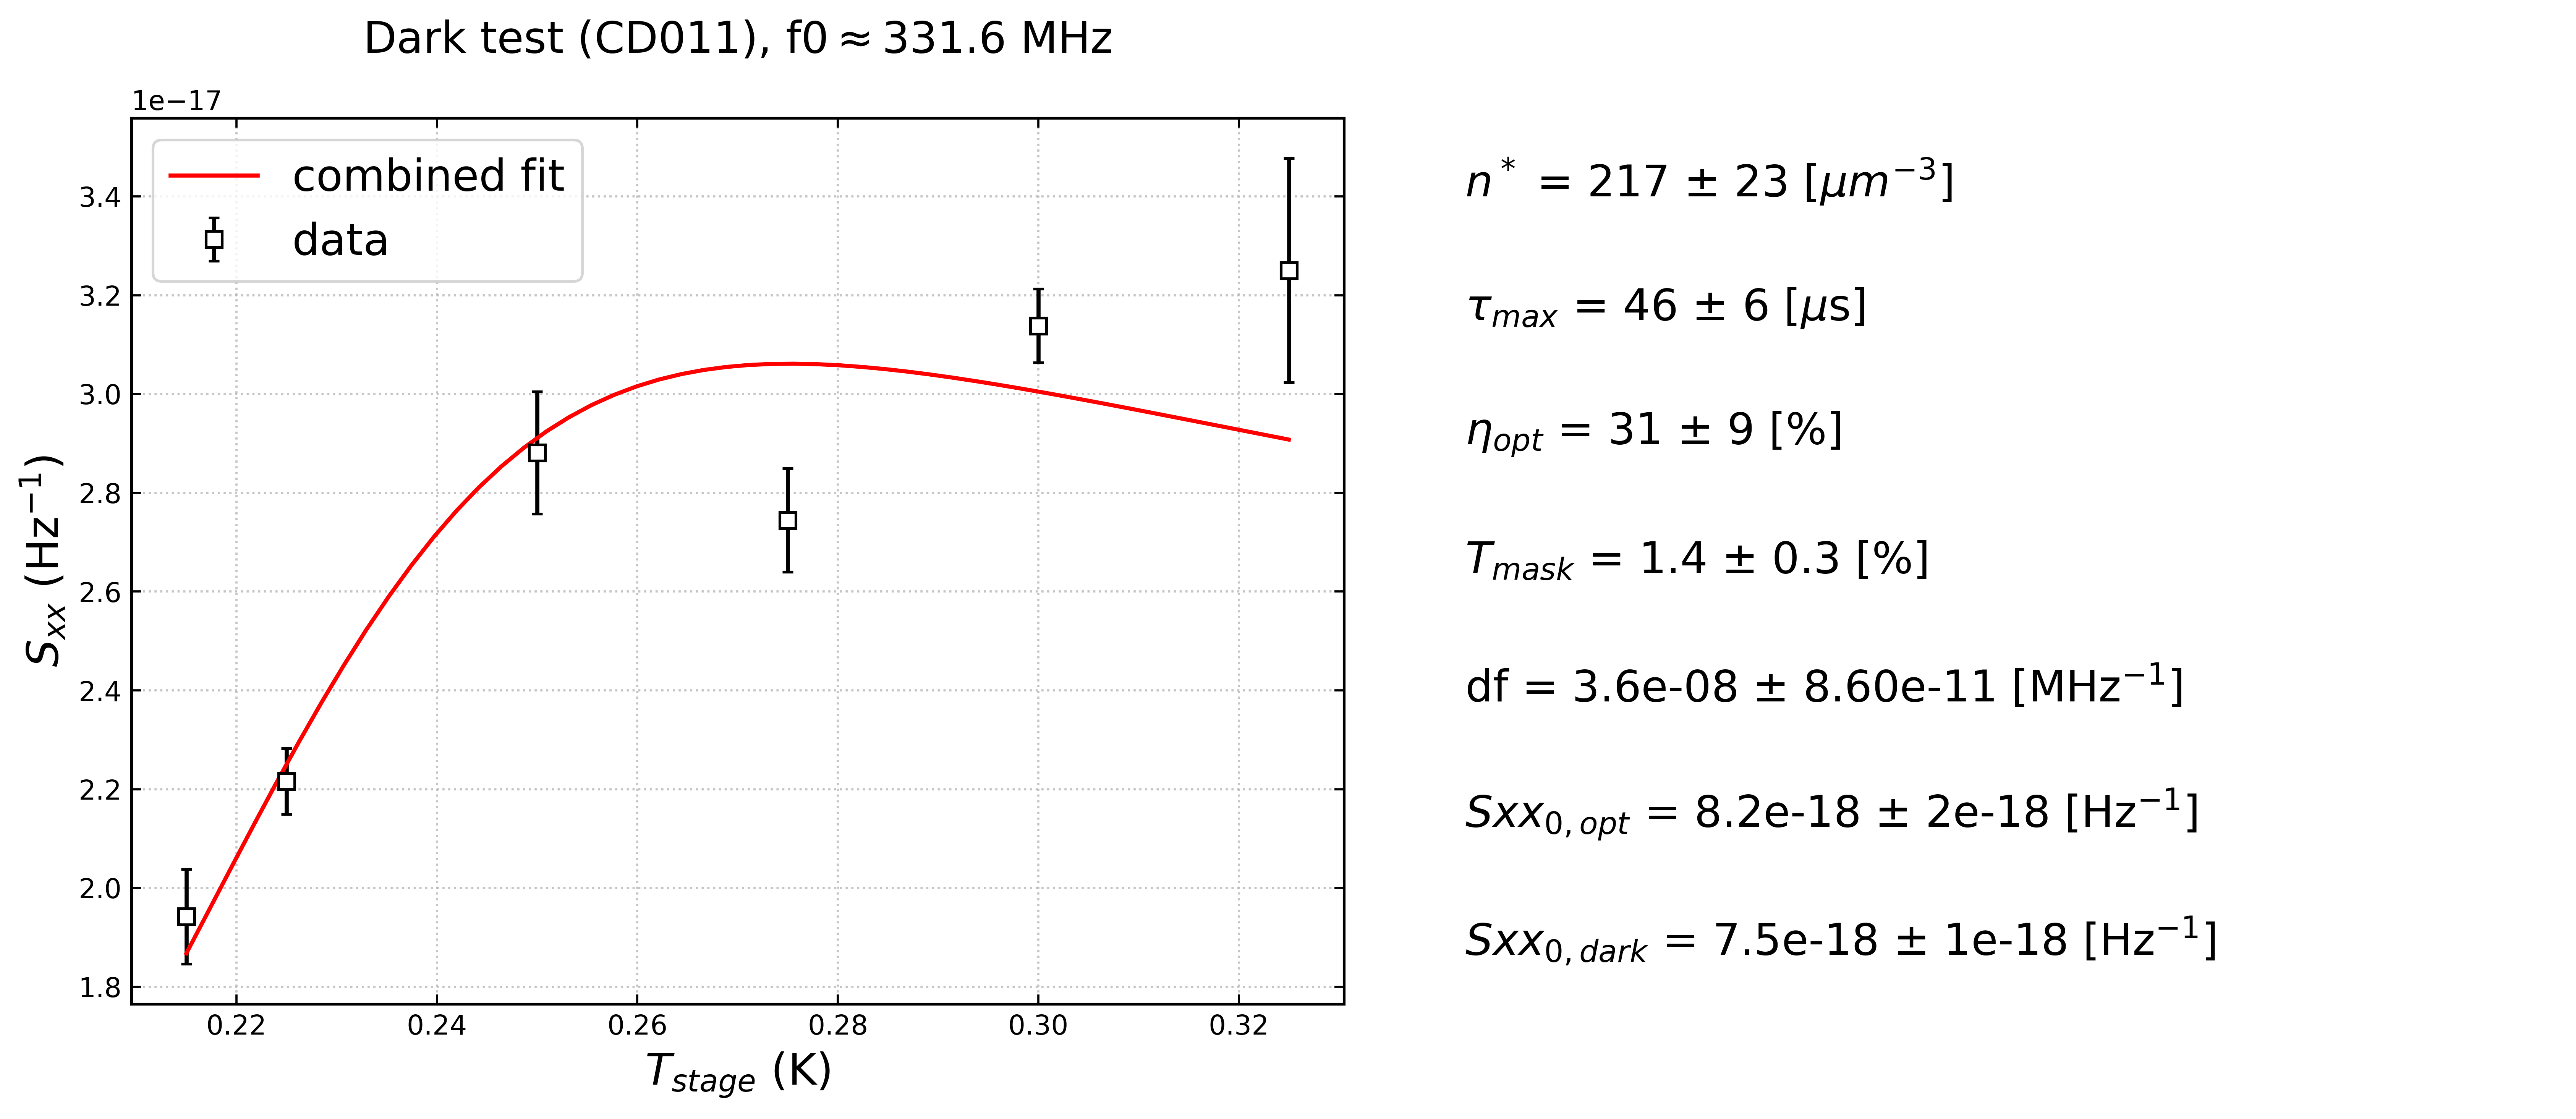

In [17]:
plt.figure(figsize=(8,6),dpi=512,facecolor=None)
plt.errorbar(x=Tstagedarkpts,y=sxxdarkpts,yerr=sxxdarkerr,linestyle=None,fmt='s',markerfacecolor='w',markeredgecolor='k',ecolor='k',label='data')
plt.plot(Tstagefit,sxxdarkfit,'r-',label='combined fit')
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.xlabel(r'$T_{stage}$ (K)',fontsize=16)
plt.ylabel(r'$S_{xx}$ (Hz$^{-1}$)',fontsize=16)
plt.title(r'Dark test (CD011), f0$\approx$331.6 MHz'+'\n',fontsize=16)
plt.legend(loc='upper left',fontsize=16)

the_table = plt.table(cellText=cell_text, loc='right',cellLoc='left',bbox=[1.0, 0, 1, 1])
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)    
for key, cell in the_table.get_celld().items():
    cell.set_linewidth(0)

if save==True: plt.savefig('C:\\Users\\Alyssa\\Penn Google Drive\\Penn & NSTRF\\Caltech Devices\\Evap_Devices_Analysis\\evap_devices\\trifitplots\\CD011_res0_Sxx_vs_Tstage_'+plotlabel+'.png')

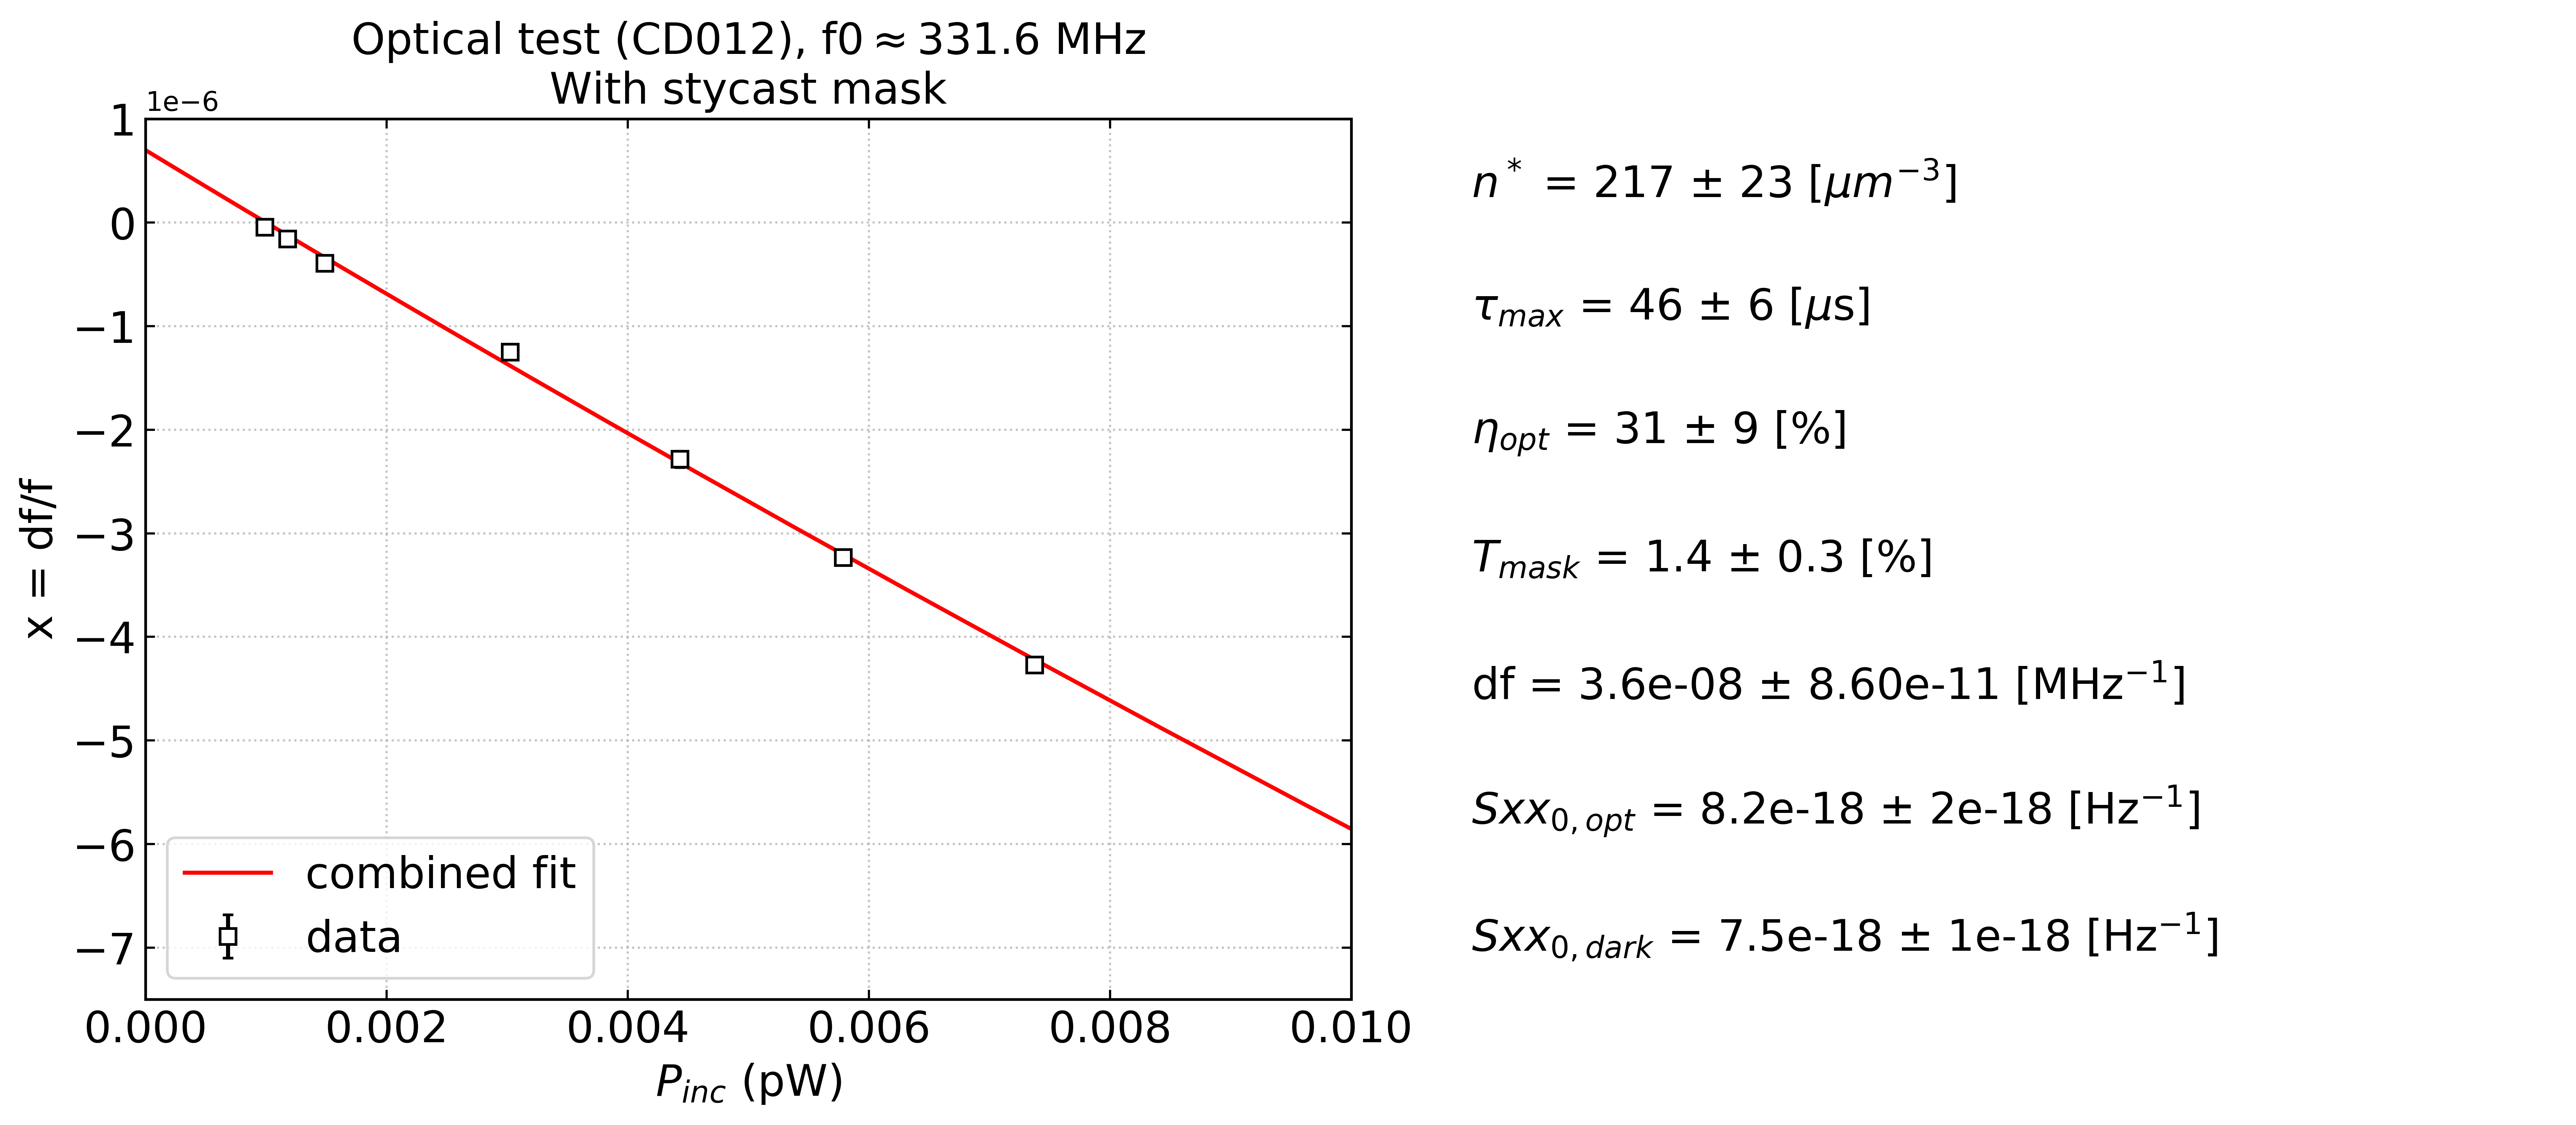

In [57]:
plt.figure(figsize=(8,6),dpi=512,facecolor=None)
plt.errorbar(x=Pincoptpts.value,y=xoptpts,yerr=xopterr,linestyle=None,fmt='s',markerfacecolor='w',markeredgecolor='k',ecolor='k',label='data')
plt.plot(kids.TBB_to_Pinc(TBBfit,trans),xoptfit,'r-',label='combined fit')
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.xlabel(r'$P_{inc}$ (pW)',fontsize=16)
plt.xlim([0,0.01])
plt.ylabel('x = df/f',fontsize=16)
plt.ylim([-0.75e-5,1e-6])
plt.tick_params(axis='both',labelsize=16)
plt.title(r'Optical test (CD012), f0$\approx$331.6 MHz' + '\n' + 'With stycast mask',fontsize=16)
plt.legend(loc='lower left',fontsize=16)

the_table = plt.table(cellText=cell_text, loc='right',cellLoc='left',bbox=[1.0, 0, 1, 1])
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)    
for key, cell in the_table.get_celld().items():
    cell.set_linewidth(0)

if save==True: plt.savefig('C:\\Users\\Alyssa\\Penn Google Drive\\Penn & NSTRF\\Caltech Devices\\Evap_Devices_Analysis\\evap_devices\\trifitplots\\CD012_res0_x_vs_Pinc_'+plotlabel+'.png')

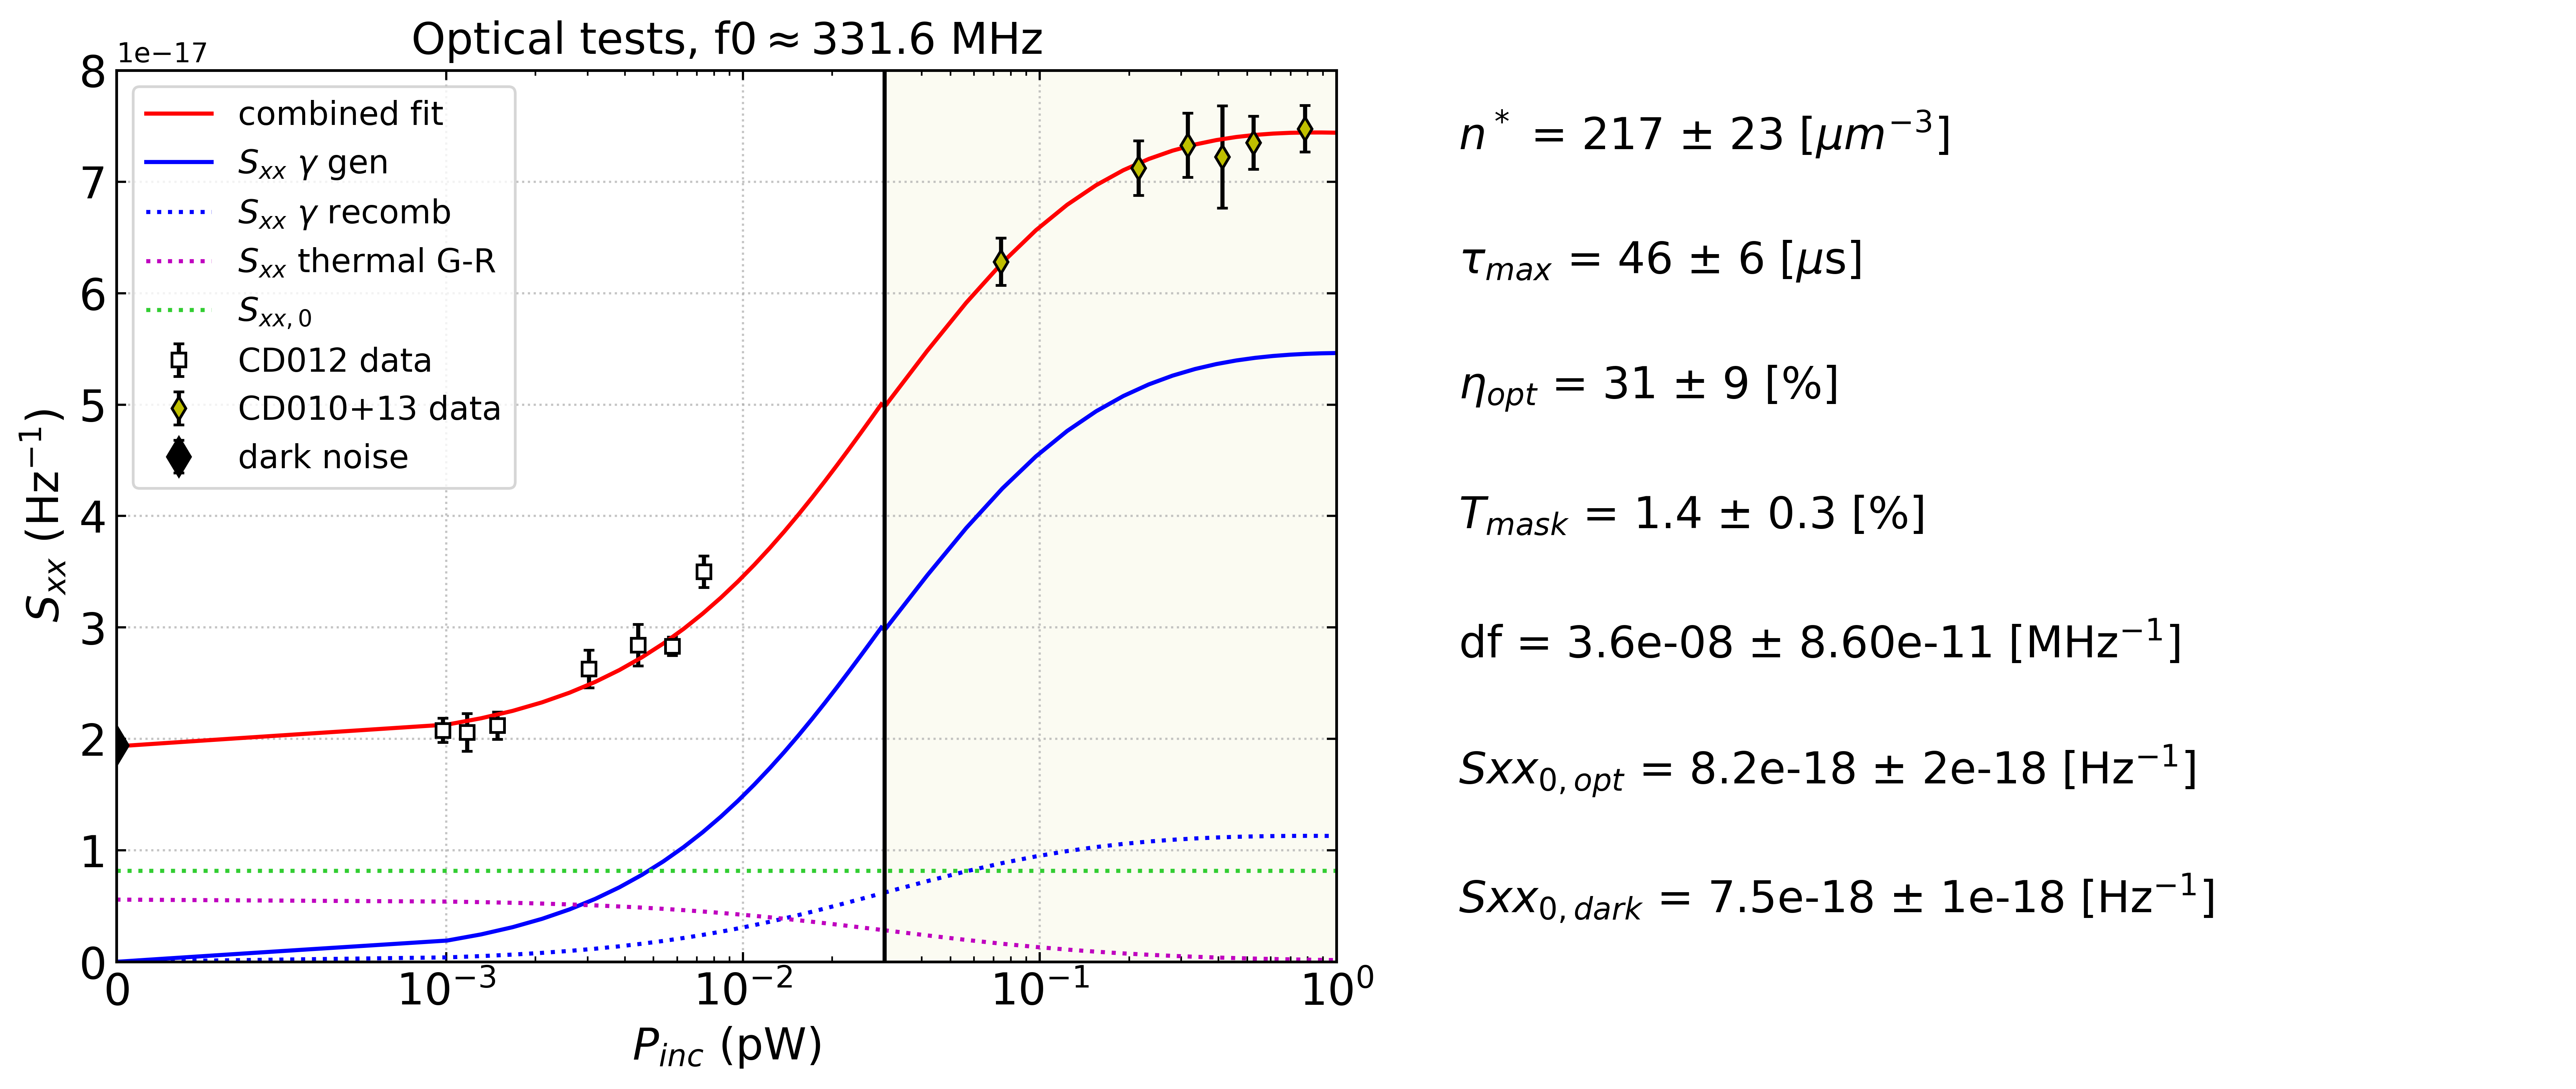

In [55]:
plt.figure(figsize=(8,6),dpi=512,facecolor=None)
plt.errorbar(x=Pincoptpts.value,y=sxxoptpts,yerr=sxxopterr,linestyle=None,fmt='s',markersize=5,markerfacecolor='w',markeredgecolor='k',ecolor='k',label='CD012 data')
plt.plot(kids.TBB_to_Pinc(TBBfit,trans),sxxoptfit,'r-',linewidth=1.5,label='combined fit')
plt.plot(kids.TBB_to_Pinc(TBBfit,trans),SxxGphoton,linestyle='-',linewidth=1.5,color='b',label=r'$S_{xx}$ $\gamma$ gen')
plt.plot(kids.TBB_to_Pinc(TBBfit,trans),SxxRphoton,linestyle=':',linewidth=1.5,color='b',label=r'$S_{xx}$ $\gamma$ recomb')
plt.plot(kids.TBB_to_Pinc(TBBfit,trans),SxxGRth,linestyle=':',linewidth=1.5,color='m',label=r'$S_{xx}$ thermal G-R')

plt.errorbar(x=Pincfulloptpts.value,y=sxxfulloptpts,yerr=sxxfullopterr,linestyle=None,fmt='d',markerfacecolor='y',markeredgecolor='k',ecolor='k',label='CD010+13 data')
plt.plot(kids.TBB_to_Pinc(TBBfulloptfit,trans=1),sxxfulloptfit,'r-')#,label='combined fit')
plt.plot(kids.TBB_to_Pinc(TBBfulloptfit,trans=1),SxxGfullphoton,linestyle='-',linewidth=1.5,color='b')#,label=r'$S_{xx}$ photon generation')
plt.plot(kids.TBB_to_Pinc(TBBfulloptfit,trans=1),SxxRfullphoton,linestyle=':',linewidth=1.5,color='b')#,label=r'$S_{xx}$ photon recombination')
plt.plot(kids.TBB_to_Pinc(TBBfulloptfit,trans=1),SxxGRthfull,linestyle=':',linewidth=1.5,color='m')#,label=r'$S_{xx}$ thermal G-R')

plt.errorbar(x=0,y=sxxdarkpts[0],yerr=sxxdarkerr[0],fmt='o',markersize=10,markerfacecolor='k',markeredgecolor='k',ecolor='k',label='dark noise')
#plt.axhline(y=sxxdarkpts[0],color='k',linestyle='--',label='dark noise floor')

plt.axvline(x=0.03,color='k')
plt.axvspan(0.03, 1, alpha=0.05, color='y')
plt.axhline(y=Sxx0opt_fit,linestyle=':',color='limegreen',label=r'$S_{xx,0}$')
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

plt.xscale('symlog',linthreshx=1e-3,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
plt.xlim([0,1])
plt.ylim([0,8e-17])
#plt.xlim([0.5e-3,1])
plt.xlabel(r'$P_{inc}$ (pW)',fontsize=16)
#plt.grid(axis='x',which='major')
#plt.grid(axis='y',which='major') # no idea why this turns off the x grid?????
plt.ylabel(r'$S_{xx}$ (Hz$^{-1}$)',fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.title(r'Optical tests, f0$\approx$331.6 MHz',fontsize=16)
plt.legend(loc='upper left',fontsize=12)#,bbox_to_anchor=(1.03, 1.03))

the_table = plt.table(cellText=cell_text, loc='right',cellLoc='left',bbox=[1.0, 0, 1, 1])
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)    
for key, cell in the_table.get_celld().items():
    cell.set_linewidth(0)

if save==True: plt.savefig('C:\\Users\\Alyssa\\Penn Google Drive\\Penn & NSTRF\\Caltech Devices\\Evap_Devices_Analysis\\evap_devices\\trifitplots\\CD012_res0_sxx_vs_Pinc_'+plotlabel+'.png')

In [20]:
# Estimate NEP = sqrt(Sxx)/(dx/dPabs); Pabs = eta_opt*Pinc

# with T_mask = 1, T_BB = 5.75 K gives P_abs = 0.025 pW
T_BB_NEP = 5.75*u.K
print('Pabs = '+str(eta_opt_fit*kids.TBB_to_Pinc(5.75*u.K,trans=1)))
sxx_NEP = np.power(u.Hz,-1)*sxxoptfunc(T_BB_NEP,n_star_fit,tau_max_fit,1,eta_opt_fit,Sxx0opt_fit)
print('Sxx(Pabs) = ' + str(sxx_NEP))
R_calc = kids.dxdPabs(alpha,f,Tstage,Tc,T_BB_NEP,V,n_star_fit*np.power(u.micron,-3),tau_max_fit*u.microsecond,eta_pb,eta_opt_fit,1)
print('R = ' + str(R_calc))
NEP_calc = np.sqrt(sxx_NEP)/R_calc
print('NEP = ' + str(NEP_calc))

Pabs = 0.025583380896546083 pW
Sxx(Pabs) = 6.405622441251037e-17 1 / Hz
R = 374822730.3086373 1 / W
NEP = 2.1352795887690355e-17 W / Hz(1/2)


In [21]:
f0optpts

[331639972.04043347,
 331639934.1989284,
 331639856.2702586,
 331639571.42604446,
 331639228.45990777,
 331638914.5982192,
 331638570.8120308]

In [22]:
n_star_fit

217.4379357757456

In [23]:
n_star_fit
tau_max_fit

45.52248604831338

In [24]:
n_star_fit

217.4379357757456

In [25]:
tau_max_fit

45.52248604831338

In [26]:
Tc 

<Quantity 1.39 K>

In [27]:
R1 = np.power(n_star_fit*tau_max_fit,-1)

In [28]:
R1

0.00010102729200059564

In [29]:
tau_0 = 438e-9*u.second

In [30]:
R2 = (np.power(2*kids.delta0(Tc),2)/(2*N0*tau_0*np.power(c.k_B*Tc,3))).to(R1.unit)

AttributeError: 'numpy.float64' object has no attribute 'unit'

In [ ]:
R2

In [ ]:
R1/R2

In [ ]:
1./(R2*tau_max_fit)

In [ ]:
# what do good detectors look like???
alpha = 0.73*u.dimensionless_unscaled
f = 331.6*u.MHz
Tstage = 0.215*u.K
Tc = 1.1*u.K
TBB_0 = 6.0*u.K
V = 38*1.5*0.8*np.power(u.micron,3) # volume w/20nm film is 38um3, multiply by 1.5 for ~30nm film, minus 20% for overetching trace width
eta_pb = 0.57
nu_opt = (350*u.micron).to(u.GHz,equivalencies=u.spectral())
N0=1.72e10*np.power(u.micron,-3)*np.power(u.eV,-1)

tau_max = 60*u.microsecond
eta_opt = 0.6
n_star = 100*np.power(u.micron,-3)#1./(R2*tau_max_fit)

TBB = TBBfit
trans = 0.03

In [ ]:
Sxx_m1 = kids.Sxx(alpha,f,Tstage,Tc,TBB,V,n_star,tau_max,eta_pb,nu_opt,eta_opt,trans,N0)

In [ ]:
plt.errorbar(x=kids.TBB_to_Pinc(TBBoptpts,trans).value,y=sxxoptpts,yerr=sxxopterr,linestyle=None,fmt='s',markerfacecolor='w',markeredgecolor='k',ecolor='k',label='data')
plt.plot(kids.TBB_to_Pinc(TBB,trans),Sxx_m1,'g:')

In [ ]:
TBBoptpts